# AES in Python

**A Jupyter Notebook by Michael Burkhardt (mburkhardt@smu.edu)**  
for MSDS 7349 Data and Network Security  
_Last updated: 27 February 2016_

In which I attempt to implement AES-128 encryption and decryption using Python (and Numpy).
This implementation will use only 128-bit blocks and 128-bit keys.

![AES Crib Sheet](http://www.moserware.com/assets/stick-figure-guide-to-advanced/aes_act_4_scene_17_crib_sheet_576.png)
<center><i>Illustration from [MOSER 2009], used without permission</i></center>

<a name="Contents"></a>
<hr style="border-style:solid;border-color:#CC0000;border-width:3px 0 0 0;" />
## Contents

1. <a href="#Section1">Preliminaries</a> - Load libraries and some global data structures that we'll need later

2. <a href="#Section2">Illustrations</a> - State matrix and selected operating modes explained in pictures

3. <a href="#Section3">Supporting Functions</a> - several functions that support the Rijndael encryption algorithm

4. <a href="#Section4">The Encrypt Function</a> - The main event

5. <a href="#Section5">Encrypt a JPEG Image</a> - Encrypt an image file three ways


<a name="Section1"></a>
<hr style="border-style:solid;border-color:#CC0000;border-width:3px 0 0 0;" />
<a href="#Contents">Return to Contents</a>
## 1. Preliminaries

Load libraries and some global data structures that we'll need later

In [1]:
# ----------------------------------------------------------------
# Custom hexadecimal formatter
# ----------------------------------------------------------------
def myhex(d):
    return("%02X" % d)

In [2]:
# ----------------------------------------------------------------
# Load some libraries
# ----------------------------------------------------------------
import numpy as np

# Always print hexadecimal numbers using my custom formatter
np.set_printoptions(formatter={'int':myhex},precision=2)

import struct

In [3]:
# ----------------------------------------------------------------
# Pre load some useful tables
# ----------------------------------------------------------------

# hard code the Rijndael substitution box (S-Box), based on [WIKI 2016b]
sbox = [
    0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
    0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
    0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
    0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
    0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
    0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
    0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
    0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
    0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
    0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
    0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
    0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
    0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
    0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
    0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
    0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
]

# This matrix is used in the MixColumns() function.
mix = np.array([[2,3,1,1],
               [1,2,3,1],
               [1,1,2,3],
               [3,1,1,2]])

# Only the first 10 vectors are needed for AES-128
rcon =[
    [0x8d, 0, 0, 0],
    [0x01, 0, 0, 0],
    [0x02, 0, 0, 0],
    [0x04, 0, 0, 0],
    [0x08, 0, 0, 0],
    [0x10, 0, 0, 0],
    [0x20, 0, 0, 0],
    [0x40, 0, 0, 0],
    [0x80, 0, 0, 0],
    [0x1b, 0, 0, 0],
    [0x36, 0, 0, 0]
]

In [4]:
# --------------------------------------------------------------------
# Lifted this code from the Internet ([DEEPLOOK 2013]) for displaying
# images inline in a Jupyter Notebook
# --------------------------------------------------------------------
from io import BytesIO
from IPython.core import display
from PIL import Image

def display_pil_image(im):
    # Displayhook function for PIL Images, rendered as PNG.
    b = BytesIO()
    im.save(b, format='png')
    data = b.getvalue()
    ip_img = display.Image(data=data, format='png', embed=True)
    return ip_img._repr_png_()

# register display func with PNG formatter:
png_formatter = get_ipython().display_formatter.formatters['image/png']
dpi = png_formatter.for_type(Image.Image, display_pil_image)

<a name="Section2"></a>
<hr style="border-style:solid;border-color:#CC0000;border-width:3px 0 0 0;" />
<a href="#Contents">Return to Contents</a>
## 2. Illustrations

### The State matrix

The intermediate steps of the AES encryption algorithm involve actions on 16-byte blocks stored in 4×4 matrices. A block that starts as the following sequence of bytes:

    1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16

is reshaped and transposed to form the following matrix:

     1  5  9 13
     2  6 10 14
     3  7 11 15
     4  8 12 16

![The AES State Matrix](http://www.moserware.com/assets/stick-figure-guide-to-advanced/aes_act_3_scene_03_state_matrix_576.png)
<center>_Construction of the State matrix (from [MOSER], used without permission)_</center>

### Encryption Modes
The pictures in this section (from [WIKI 2016a]) illustrate the three AES modes that I'm going to implement for this assignment.
![!](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d6/ECB_encryption.svg/601px-ECB_encryption.svg.png)
![!](https://upload.wikimedia.org/wikipedia/commons/thumb/8/80/CBC_encryption.svg/601px-CBC_encryption.svg.png)
![!](https://upload.wikimedia.org/wikipedia/commons/thumb/4/4d/CTR_encryption_2.svg/601px-CTR_encryption_2.svg.png)

<a name="Section3"></a>
<hr style="border-style:solid;border-color:#CC0000;border-width:3px 0 0 0;" />
<a href="#Contents">Return to Contents</a>

## 3. Supporting Functions

* **<a href="#SubBytes">SubBytes</a>** Replace each byte value in the State matrix with a value from the _Substitution Box_
* **<a href="#ShiftRows">ShiftRows</a>** Perform row-wise circular shifts on the State matrix
* **<a href="#AddRoundKey">AddRoundKey</a>** Bytewise XOR of state matrix with round key
* **<a href="#gfmul">gfmul</a>** Implement finite Galois field multiplication function
* **<a href="#MixColumns">MixColumns</a>** There be some dark magic here
* **<a href="#RotWord">RotWord</a>** Perform a circular shift on an array of 4 bytes
* **<a href="#SubWord">SubWord</a>** Apply sbox substitution to all bytes of an array
* **<a href="#ExpandKey">ExpandKey</a>** Generate the round keys
* **<a href="#EncryptBlock">EncryptBlock</a>** Perform encryption step on a single 16-byte block
* **<a href="#PadBlock">PadBlock</a>** Pad a short block with nulls
* **<a href="#PackCount">PackCount</a>** Pack the counter into a 16-byte serialized block

<a name="SubBytes"></a>
<hr style="border-style:solid;border-color:#6666FF;border-width:3px 0 0 0;" />
Return to <a href="#Section3">Supporting Functions</a> | <a href="#Contents">Contents</a>
### SubBytes()

In [5]:
# ----------------------------------------------------------------
# Implement the ByteSub() function (See [DAEMEN 1999], §4.2.1)
# Usage: b = SubBytes(a)
# where b and a are both 4×4 numpy arrays
# ----------------------------------------------------------------
def SubBytes(State):
    assert State.shape == (4,4)
    return(np.array(map(lambda x: map(lambda y: sbox[y],x),State),dtype=np.uint8))

In [6]:
# ----------------------------------------------------------------
# Test the SubBytes() function:
# ----------------------------------------------------------------
a = np.arange(1,17,dtype=np.uint8).reshape(4,4).T
print "a:\n", a
ax = SubBytes(a)
print "ax:\n", ax

a:
[[01 05 09 0D]
 [02 06 0A 0E]
 [03 07 0B 0F]
 [04 08 0C 10]]
ax:
[[7C 6B 01 D7]
 [77 6F 67 AB]
 [7B C5 2B 76]
 [F2 30 FE CA]]


<a name="ShiftRows"></a>
<hr style="border-style:solid;border-color:#6666FF;border-width:3px 0 0 0;" />
Return to <a href="#Section3">Supporting Functions</a> | <a href="#Contents">Contents</a>
### ShiftRows()

In [7]:
# ----------------------------------------------------------------
# Implement the ShiftRows() function (See [DAEMEN 1999], §4.2.1)
# Usage: b = ShiftRows(a)
# where b and a are both 4×4 numpy arrays
# ----------------------------------------------------------------

# Example:
# from            to
#  1  5  9 13      1  5  9 13
#  2  6 10 14      6 10 14  2
#  3  7 11 15     11 15  3  7
#  4  8 12 16     16  4  8 12

def ShiftRows(State):
    assert State.shape == (4,4)
    t = np.array([
                State[0],
                np.roll(State[1],-1),
                np.roll(State[2],-2),
                np.roll(State[3],-3)
            ])
    return(t)

In [8]:
# ----------------------------------------------------------------
# Test ShiftRows()
# ----------------------------------------------------------------
a = np.arange(1,17).reshape(4,4).T
print "a:\n", a

ashift = ShiftRows(a)
print "ashift:\n", ashift

a:
[[01 05 09 0D]
 [02 06 0A 0E]
 [03 07 0B 0F]
 [04 08 0C 10]]
ashift:
[[01 05 09 0D]
 [06 0A 0E 02]
 [0B 0F 03 07]
 [10 04 08 0C]]


<a name="AddRoundKey"></a>
<hr style="border-style:solid;border-color:#6666FF;border-width:3px 0 0 0;" />
Return to <a href="#Section3">Supporting Functions</a> | <a href="#Contents">Contents</a>
### AddRoundKey()
![!](http://upload.wikimedia.org/wikipedia/commons/thumb/a/ad/AES-AddRoundKey.svg/320px-AES-AddRoundKey.svg.png)

In [9]:
# ----------------------------------------------------------------
# Implement the ShiftRows() function (See [DAEMEN 1999], §4.2.1)
# XOR each byte of the roundKey with the state table
# Usage: b = AddRoundKey(a,key)
# where b and a are both 4×4 numpy arrays
# ----------------------------------------------------------------
def AddRoundKey(State, roundKey):
    return(State ^ roundKey)

In [10]:
# ----------------------------------------------------------------
# Test AddRoundKey()
# The 4×4 matrix that we're passing to AddRoundKey() must already be transformed in
# vertically oriented words.
# Usage: b = AddRoundKey(a,k)
# ----------------------------------------------------------------

# Test data from Appendix B of [NIST 2001]
a = np.array([0x32,0x43,0xF6,0xA8,0x88,0x5A,0x30,0x8D,0x31,0x31,0x98,0xA2,0xE0,0x37,0x07,0x34],dtype=np.uint8).reshape(4,4).T
print "a (plaintext):\n", a

# Test data from Appendix B of [NIST 2001]
k = np.array([0x2B,0x7E,0x15,0x16,0x28,0xAE,0xD2,0xA6,0xAB,0xF7,0x15,0x88,0x09,0xCF,0x4F,0x3C],dtype=np.uint8).reshape(4,4).T
print "k (round key):\n", k

b = AddRoundKey(a,k)
print "ax:\n", b

a (plaintext):
[[32 88 31 E0]
 [43 5A 31 37]
 [F6 30 98 07]
 [A8 8D A2 34]]
k (round key):
[[2B 28 AB 09]
 [7E AE F7 CF]
 [15 D2 15 4F]
 [16 A6 88 3C]]
ax:
[[19 A0 9A E9]
 [3D F4 C6 F8]
 [E3 E2 8D 48]
 [BE 2B 2A 08]]


<a name="gfmul"></a>
<hr style="border-style:solid;border-color:#6666FF;border-width:3px 0 0 0;" />
Return to <a href="#Section3">Supporting Functions</a> | <a href="#Contents">Contents</a>
### gfmul()

In [11]:
# ----------------------------------------------------------------
# Multiply two elemnts of the Galois Field(256)
# ----------------------------------------------------------------
def gfmul(a,b):
    assert a <= 255
    assert b <= 255
    aa = a
    bb = b
    r = 0
    #while (aa != 0):
    for i in range(8):
        if ((aa & 1) != 0):
            r = r ^ bb
        t = bb & 0x80
        bb = bb << 1
        if (t != 0):
            bb = bb ^ 0x1b
        aa = aa >> 1
    return r

<a name="MixColumns"></a>
<hr style="border-style:solid;border-color:#6666FF;border-width:3px 0 0 0;" />
Return to <a href="#Section3">Supporting Functions</a> | <a href="#Contents">Contents</a>
## MixColumns()

In [12]:
# ----------------------------------------------------------------
# Implement MixColumns (not very Pythonic)
# ----------------------------------------------------------------
def MixColumns(State):
    mc = np.zeros((4,4),dtype=np.uint8) # Create empty result matrix
    st = State.T       # temporary transposed State matrix
    for i in range(4):
        mix_row = mix[i]
        for j in range(4):
            r = 0x00
            state_column = st[j]
            for k in range(4):
                r = r ^ gfmul(state_column[k],mix_row[k])
            mc[i][j] = r
    return(mc)

In [13]:
# ----------------------------------------------------------------
# Test MixColumns() (Test data from [JAIN 2011], page 12)
# ----------------------------------------------------------------
a = np.array([[0xAB,0x8B,0x89,0x35],
             [0x40,0x7F,0xF1,0x05],
             [0xF0,0xFC,0x18,0x3F],
             [0xC4,0xE4,0x4E,0x2F]])
print "a:\n", a
print type(a)

mc = MixColumns(a)
print "mc:\n", mc

a:
[[AB 8B 89 35]
 [40 7F F1 05]
 [F0 FC 18 3F]
 [C4 E4 4E 2F]]
<type 'numpy.ndarray'>
mc:
[[B9 94 57 75]
 [E4 8E 16 51]
 [47 20 9A 3F]
 [C5 D6 F5 3B]]


<a name="RotWord"></a>
<hr style="border-style:solid;border-color:#6666FF;border-width:3px 0 0 0;" />
Return to <a href="#Section3">Supporting Functions</a> | <a href="#Contents">Contents</a>
### RotWord()

In [14]:
# ----------------------------------------------------------------
# RotWord(w) - perform a circular shift on an array of 4 bytes:
# from [1,2,3,4] to [2,3,4,1]
# Usage: b = RotWord(a)
# Where a and b are both 4-byte words (as numpy arrays)
# --------------------------------------------------------------------
def RotWord(W):
    assert len(W) == 4
    return(np.roll(W,-1))

In [15]:
# --------------------------------------------------------------------
# Test RotWord()
# --------------------------------------------------------------------
a = np.array([1,2,3,4])
print RotWord(a)

[02 03 04 01]


<a name="SubWord"></a>
<hr style="border-style:solid;border-color:#6666FF;border-width:3px 0 0 0;" />
Return to <a href="#Section3">Supporting Functions</a> | <a href="#Contents">Contents</a>
### SubWord()

In [16]:
# --------------------------------------------------------------------
# SubWord(W) - trivial implementation that applies sbox substitution
# to a 4-byte word.
# --------------------------------------------------------------------
def SubWord(W):
    return(np.array(map(lambda y: sbox[y],W),dtype=np.uint8))

In [17]:
# --------------------------------------------------------------------
# Test SubWord()
# --------------------------------------------------------------------
a = np.array([252,253,254,255])
print SubWord(a)

[B0 54 BB 16]


<a name="ExpandKey"></a>
<hr style="border-style:solid;border-color:#6666FF;border-width:3px 0 0 0;" />
Return to <a href="#Section3">Supporting Functions</a> | <a href="#Contents">Contents</a>
### ExpandKey()

In [18]:
# --------------------------------------------------------------------
# expkey = ExpandKey(Key)
# where Key is a 16-byte key as a numpy array of shape (16,)
# and expkey is numpy (3D) array indexed on [round][row][col]
# This function is hard coded for AES-128, which uses 11 total 8-byte words (176 bytes),
# for a total of 44 8-byte words
# --------------------------------------------------------------------
def ExpandKey(Key):
    KeyWords = Key.reshape(4,4) # untransformed list of key (4-byte) words
    Nk = len(KeyWords)
    assert Nk == 4, "Nk must be 4 for AES-128 (got %d)" % Nk
    W = np.zeros((44,4),dtype=np.uint8)

    # populate the first four words with the original key
    for i in range(Nk):
        W[i] = KeyWords[i]

    # Build the remaining words
    for i in range(Nk,44):
        rconIter = int(i/Nk)
        t = W[i-1]
        if ( i % Nk == 0 ):
            t = SubWord(RotWord(t)) ^ rcon[rconIter]
        W[i] = W[i - Nk] ^ t

    # Now we've got a sequence of words
    #print "Words:\n", W

    XK = np.zeros((11,16),dtype=np.uint8)
    
    # Generate the Round Keys
    for i in range(1,12):
        rkey = W[(i-1)*4:i*4].flatten() # This is the round (i-1) key!
        #print "Round %d key: %s" % (i-1,rkey)
        XK[i-1] = rkey
    
    return(XK)

In [19]:
# --------------------------------------------------------------------
# Test ExpandKey()
# --------------------------------------------------------------------

# This key is from Appendix A of [NIST]
k = np.array([0x2B,0x7E,0x15,0x16,0x28,0xAE,0xD2,0xA6,0xAB,0xF7,0x15,0x88,0x09,0xCF,0x4F,0x3C])

# This key is from 
print "key:\n", k
xk = ExpandKey(k)
for rnd in range(11):
    print "Round %d key: %s" % (rnd,xk[rnd])

key:
[2B 7E 15 16 28 AE D2 A6 AB F7 15 88 09 CF 4F 3C]
Round 0 key: [2B 7E 15 16 28 AE D2 A6 AB F7 15 88 09 CF 4F 3C]
Round 1 key: [A0 FA FE 17 88 54 2C B1 23 A3 39 39 2A 6C 76 05]
Round 2 key: [F2 C2 95 F2 7A 96 B9 43 59 35 80 7A 73 59 F6 7F]
Round 3 key: [3D 80 47 7D 47 16 FE 3E 1E 23 7E 44 6D 7A 88 3B]
Round 4 key: [EF 44 A5 41 A8 52 5B 7F B6 71 25 3B DB 0B AD 00]
Round 5 key: [D4 D1 C6 F8 7C 83 9D 87 CA F2 B8 BC 11 F9 15 BC]
Round 6 key: [6D 88 A3 7A 11 0B 3E FD DB F9 86 41 CA 00 93 FD]
Round 7 key: [4E 54 F7 0E 5F 5F C9 F3 84 A6 4F B2 4E A6 DC 4F]
Round 8 key: [EA D2 73 21 B5 8D BA D2 31 2B F5 60 7F 8D 29 2F]
Round 9 key: [AC 77 66 F3 19 FA DC 21 28 D1 29 41 57 5C 00 6E]
Round 10 key: [D0 14 F9 A8 C9 EE 25 89 E1 3F 0C C8 B6 63 0C A6]


<a name="EncryptBlock"></a>
<hr style="border-style:solid;border-color:#6666FF;border-width:3px 0 0 0;" />
Return to <a href="#Section3">Supporting Functions</a> | <a href="#Contents">Contents</a>
### EncryptBlock()
This is a milestone here, folks. This is the point at which we're finally able to encrypt exactly one block of plaintext. Woohoo!

In [20]:
# ---------------------------------------------------------
# Usage ciphertext = Encrypt(plaintext)
# where ciphertext and plaintext are both 16-byte blocks,
# as numpy (one-dimensional) arrays.
# ---------------------------------------------------------
def EncryptBlock(Plaintext, Key, debug=False):

    # Make sure our inputs are the right shape (should also check for type, but I'm lazy)
    assert Plaintext.shape == (16,), "Plaintext must be an array of 16 bytes. (got %s)" % str(Plaintext.shape)
    assert Key.shape == (16,), "Key must be an array of 16 bytes. (got %s)" % str(Key.shape)
    
    # I'll handle the conversion to a 2-dimensional matrix, thankyouverymuch
    State = Plaintext.reshape(4,4).T
    
    # Get the Round Keys
    RoundKeys = ExpandKey(Key)
    
    # (PART 1 of 3) Round 0
    if debug:
        print "-" * 78
        print "ROUND 0"
        print "-" * 78
        print "State (before Add Round Key):\n", State

    rk = RoundKeys[0]
    if debug:
        print "Round 0 key:\n", rk
    State = AddRoundKey(State,rk.reshape(4,4).T)

    # (PART 2 of 3) Rounds 1 through 9
    for i in range(1,11):

        if debug:
            print "-" * 78
            print "ROUND %d" % i
            print "-" * 78
            # State at start of round
            print "At start of round %d:\n" % i, State
        
        # Substitute Bytes
        State = SubBytes(State)
        if debug:
            print "After SubBytes():\n", State

        # Shift Rows
        State = ShiftRows(State)
        if debug:
            print "After ShiftRows():\n", State
        
        # Mix Columns (skip on final round)
        if i < 10:
            State = MixColumns(State)
            if debug:
                print "After MixColumns():\n", State
        
        # Add this round's key
        rk = RoundKeys[i]
        if debug:
            print "Round %d key:\n" % i, rk
        State = AddRoundKey(State,rk.reshape(4,4).T)

    return(State)

In [21]:
# ---------------------------------------------------------
# Test EncryptBlock()... We'll use the plaintext block and
# key listed in Appendix B of [NIST 2001]
# ---------------------------------------------------------
plaintext = np.array([0x32,0x43,0xF6,0xA8,0x88,0x5A,0x30,0x8D,0x31,0x31,0x98,0xA2,0xE0,0x37,0x07,0x34],dtype=np.uint8)
key = np.array([0x2B,0x7E,0x15,0x16,0x28,0xAE,0xD2,0xA6,0xAB,0xF7,0x15,0x88,0x09,0xCf,0x4F,0x3C],dtype=np.uint8)

# Convert these to vertically-oriented 4×4 blocks
plaintext_block = plaintext.reshape(4,4).T
key_block = key.reshape(4,4).T

# Then pass the blocks to the Encrypt() function
ciphertext_block = EncryptBlock(plaintext,key,True)
ciphertext = ciphertext_block.T.flatten()

print ciphertext

------------------------------------------------------------------------------
ROUND 0
------------------------------------------------------------------------------
State (before Add Round Key):
[[32 88 31 E0]
 [43 5A 31 37]
 [F6 30 98 07]
 [A8 8D A2 34]]
Round 0 key:
[2B 7E 15 16 28 AE D2 A6 AB F7 15 88 09 CF 4F 3C]
------------------------------------------------------------------------------
ROUND 1
------------------------------------------------------------------------------
At start of round 1:
[[19 A0 9A E9]
 [3D F4 C6 F8]
 [E3 E2 8D 48]
 [BE 2B 2A 08]]
After SubBytes():
[[D4 E0 B8 1E]
 [27 BF B4 41]
 [11 98 5D 52]
 [AE F1 E5 30]]
After ShiftRows():
[[D4 E0 B8 1E]
 [BF B4 41 27]
 [5D 52 11 98]
 [30 AE F1 E5]]
After MixColumns():
[[04 E0 48 28]
 [66 CB F8 06]
 [81 19 D3 26]
 [E5 9A 7A 4C]]
Round 1 key:
[A0 FA FE 17 88 54 2C B1 23 A3 39 39 2A 6C 76 05]
------------------------------------------------------------------------------
ROUND 2
------------------------------------------

<a name="PadBlock"></a>
<hr style="border-style:solid;border-color:#6666FF;border-width:3px 0 0 0;" />
Return to <a href="#Section3">Supporting Functions</a> | <a href="#Contents">Contents</a>
### PadBlock()

In [22]:
# --------------------------------------------------------------------
# PadBlock() - pad blocks shorter than 16 bytes (and longer than 0)
# --------------------------------------------------------------------
def PadBlock(Block):
    assert type(Block) == np.ndarray
    BlockLength = len(Block) % 16
    if 0 < BlockLength and BlockLength < 16:
        Block = np.append(Block,[0]*(16-BlockLength))
    return(Block)

In [23]:
# --------------------------------------------------------------------
# Test the PadBlock() function
# --------------------------------------------------------------------
a = np.arange(12) # Create a "short" block
print "Original block:", a
b = PadBlock(a)
print "Padded block:  ", b
c = PadBlock(b) # a block that is already 16 bytes should not be padded.
print "Third block:   ", c

Original block: [00 01 02 03 04 05 06 07 08 09 0A 0B]
Padded block:   [00 01 02 03 04 05 06 07 08 09 0A 0B 00 00 00 00]
Third block:    [00 01 02 03 04 05 06 07 08 09 0A 0B 00 00 00 00]


<a name="PackCount"></a>
<hr style="border-style:solid;border-color:#6666FF;border-width:3px 0 0 0;" />
Return to <a href="#Section3">Supporting Functions</a> | <a href="#Contents">Contents</a>
### PackCount()

In [24]:
# --------------------------------------------------------------------
# PackCount - Given a (potentially large) integer, pack it into
# a numpy array. (There MUST be a better way to do this!)
# We'll use this for CTR mode.
# --------------------------------------------------------------------
def PackCount(n):
    packed_block = np.array([],dtype=np.uint8)
    for i in range(16):
        if n > 0:
            a = n & 0xFF
            n >>= 8
            packed_block = np.insert(packed_block,0,a)
        else:
            packed_block = np.insert(packed_block,0,0)
    return(packed_block)

In [25]:
# --------------------------------------------------------------------
# Test PackCount
# --------------------------------------------------------------------
print PackCount(1)
print PackCount(15)
print PackCount(256)
print PackCount(123456)

[00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 01]
[00 00 00 00 00 00 00 00 00 00 00 00 00 00 00 0F]
[00 00 00 00 00 00 00 00 00 00 00 00 00 00 01 00]
[00 00 00 00 00 00 00 00 00 00 00 00 00 01 E2 40]


<a name="Section4"></a>
<hr style="border-style:solid;border-color:#CC0000;border-width:3px 0 0 0;" />
<a href="#Contents">Return to Contents</a>
## 4. The Encrypt Function

In [26]:
# --------------------------------------------------------------------
# Encrypt()
# Usage: ciphertext = Encrypt(plaintest,key)
# where plaintext is a numpy array of bytes having arbitrary length,
# and key is a 16-byte key, as a one-dimensional numpy array.
# This version effectively implements ECB mode encryption.
# --------------------------------------------------------------------
def Encrypt(P,K,mode='ecb',debug=False):
    assert type(P) == np.ndarray
    assert K.shape == (16,)
    assert mode in ['ecb','cbc','ctr']

    print "Encrypting with mode %s." % mode

    # Pad with nulls if last block is shorter than 16 bytes
    #lastBlockLength = len(P) % 16
    #if 0 < lastBlockLength and lastBlockLength < 16:
    #    P = np.append(P,[0]*(16-lastBlockLength))
    P = PadBlock(P)
    C = np.array([])
    last_cbc_block = np.array([0]*16,dtype=np.uint8)

    # Iterate over blocks
    block_num = 0
    block_tot = len(P) / 16
    pct_done_last = 0
    while len(P) > 0:
        
        # Are we there yet?
        pct_done = int(float(block_num)/block_tot*100)
        if pct_done > pct_done_last:
            pct_done_last = pct_done
            print "Processing block %d of %d (%d%% complete)" % (block_num,block_tot,pct_done)

        # Pull the next block (this_block), shortening the plaintext block (P)
        this_block = P[:16]
        P = P[16:]

        if debug:
            print "This block:", this_block

        # Implement extra step for CBC mode, in which we XOR the current
        # plaintext block with the previous block of ciphertext prior
        # to the encryption step
        if mode == 'cbc':
            this_block = this_block ^ last_cbc_block

        # Perform the encryption step on this block
        if mode == 'ctr':
            ctr_block = PackCount(block_num)
            if debug:
                print "Counter block:", ctr_block
            this_C = EncryptBlock(ctr_block,K,debug).T.flatten() ^ this_block
        else:
            this_C = EncryptBlock(this_block,K,debug).T.flatten()

        # save a copy of this block for use with the next block (CBC mode only)
        last_cbc_block = this_C.copy()

        if debug:
            print "This encrypted block: ", this_C

        C = np.append(C,this_C) # Append the encrypted block to the Ciphertext
        block_num += 1
    
    return(C.astype(np.uint8))

In [27]:
# --------------------------------------------------------------------
# Test the encryption using default (ecb) mode,
# and debug enabled (so lots of output)
# --------------------------------------------------------------------

# Some arbitrary-length plaintext to be encrypted.
plaintext = "The quick brown fox jumps over the lazy dog."
plaintextArray = np.fromstring(plaintext,dtype=np.uint8)
print "Plaintext: ", plaintextArray

# Some arbitrary-length key, up to 16 characters
# (There are probably better ways to pack longer strings into byte arrays, but I will not mess with that here.)
key = "This is a key that is too long to fit into one block."
keyArray = np.fromstring(key,dtype=np.uint8)[:16]
print "Key:", keyArray

ciphertext = Encrypt(plaintextArray,keyArray,debug=True)
print "Ciphertext: ", ciphertext

Plaintext:  [54 68 65 20 71 75 69 63 6B 20 62 72 6F 77 6E 20 66 6F 78 20 6A 75 6D 70 73
 20 6F 76 65 72 20 74 68 65 20 6C 61 7A 79 20 64 6F 67 2E]
Key: [54 68 69 73 20 69 73 20 61 20 6B 65 79 20 74 68]
Encrypting with mode ecb.
This block: [54 68 65 20 71 75 69 63 6B 20 62 72 6F 77 6E 20]
------------------------------------------------------------------------------
ROUND 0
------------------------------------------------------------------------------
State (before Add Round Key):
[[54 71 6B 6F]
 [68 75 20 77]
 [65 69 62 6E]
 [20 63 72 20]]
Round 0 key:
[54 68 69 73 20 69 73 20 61 20 6B 65 79 20 74 68]
------------------------------------------------------------------------------
ROUND 1
------------------------------------------------------------------------------
At start of round 1:
[[00 51 0A 16]
 [00 1C 00 57]
 [0C 1A 09 1A]
 [53 43 17 48]]
After SubBytes():
[[63 D1 67 47]
 [63 9C 63 5B]
 [FE A2 01 A2]
 [ED 1A F0 52]]
After ShiftRows():
[[63 D1 67 47]
 [9C 63 5B 63]
 [01 A2 FE A2]

<a name="Section5"></a>
<hr style="border-style:solid;border-color:#CC0000;border-width:3px 0 0 0;" />
<a href="#Contents">Return to Contents</a>
## 5. Encrypt a JPEG Image

In [28]:
# Load an image
img = Image.open('tardis256.jpg')
#img = Image.open('dot32.jpg') # a smaller image, for testing

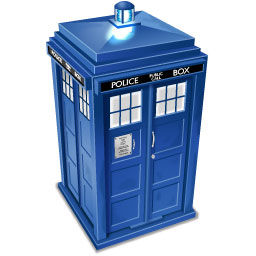

In [29]:
# Display the image
img

In [30]:
# --------------------------------------------------------------------
# Unpack the image data and serialize as a numpy array
# --------------------------------------------------------------------
imgList  = list(img.getdata())
imgArray = np.array(imgList).flatten()
print "The image list contains %d tuples." % len(imgList)
print "The first 3 tuples:", imgList[:3]
print "The flattened array of image data has %d elements." % len(imgArray)
print "Here are the first 25 elements: ", imgArray[:25]

The image list contains 65536 tuples.
The first 3 tuples: [(255, 255, 255), (255, 255, 255), (255, 255, 255)]
The flattened array of image data has 196608 elements.
Here are the first 25 elements:  [FF FF FF FF FF FF FF FF FF FF FF FF FF FF FF FF FF FF FF FF FF FF FF FF FF]


### 5.1 Encrypt Image using Electronic Code Book (ECB) mode

In [31]:
# --------------------------------------------------------------------
# And now the thrilling climax, in which we encrypt our image data
# using the default mode (ECB)
# --------------------------------------------------------------------

# Encryption key
key = "Fezes and bow ties are cool"
keyArray = np.fromstring(key,dtype=np.uint8)[:16]
print "Key:", keyArray

# the coup de grâce
img1Ciphertext = Encrypt(imgArray,keyArray)
print "Ciphertext: ", img1Ciphertext[:256] # display the first 256 bytes of the ciphertext data

# Make yourself comfortable. This takes a while to run.

Key: [46 65 7A 65 73 20 61 6E 64 20 62 6F 77 20 74 69]
Encrypting with mode ecb.
Processing block 123 of 12288 (1% complete)
Processing block 246 of 12288 (2% complete)
Processing block 369 of 12288 (3% complete)
Processing block 492 of 12288 (4% complete)
Processing block 615 of 12288 (5% complete)
Processing block 738 of 12288 (6% complete)
Processing block 861 of 12288 (7% complete)
Processing block 984 of 12288 (8% complete)
Processing block 1106 of 12288 (9% complete)
Processing block 1229 of 12288 (10% complete)
Processing block 1352 of 12288 (11% complete)
Processing block 1475 of 12288 (12% complete)
Processing block 1598 of 12288 (13% complete)
Processing block 1721 of 12288 (14% complete)
Processing block 1844 of 12288 (15% complete)
Processing block 1967 of 12288 (16% complete)
Processing block 2089 of 12288 (17% complete)
Processing block 2212 of 12288 (18% complete)
Processing block 2335 of 12288 (19% complete)
Processing block 2458 of 12288 (20% complete)
Processing block

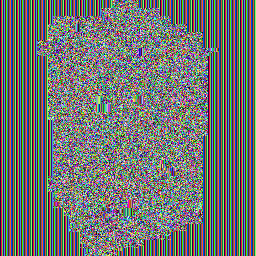

In [32]:
# --------------------------------------------------------------------
# Repack the encrypted data into an image object
# --------------------------------------------------------------------
img1CiphertextTuples = map(tuple,np.reshape(img1Ciphertext,(-1,3)))
img1 = img.copy()
img1.putdata(img1CiphertextTuples)
img1

### 5.2 Encrypt Image Using Cipher Block Chaining (CBC) mode

In [33]:
# --------------------------------------------------------------------
# And now the thrilling climax, in which we encrypt our image data
# using the cipher block chaining mode (CBC)
# --------------------------------------------------------------------

# Use previous encryption key
print "Key:", keyArray

# the coup de grâce
img2Ciphertext = Encrypt(imgArray,keyArray,mode='cbc')
print "Ciphertext: ", img2Ciphertext[:256] # display the first 256 bytes of the ciphertext data

# Make yourself comfortable. This takes a while to run.

Key: [46 65 7A 65 73 20 61 6E 64 20 62 6F 77 20 74 69]
Encrypting with mode cbc.
Processing block 123 of 12288 (1% complete)
Processing block 246 of 12288 (2% complete)
Processing block 369 of 12288 (3% complete)
Processing block 492 of 12288 (4% complete)
Processing block 615 of 12288 (5% complete)
Processing block 738 of 12288 (6% complete)
Processing block 861 of 12288 (7% complete)
Processing block 984 of 12288 (8% complete)
Processing block 1106 of 12288 (9% complete)
Processing block 1229 of 12288 (10% complete)
Processing block 1352 of 12288 (11% complete)
Processing block 1475 of 12288 (12% complete)
Processing block 1598 of 12288 (13% complete)
Processing block 1721 of 12288 (14% complete)
Processing block 1844 of 12288 (15% complete)
Processing block 1967 of 12288 (16% complete)
Processing block 2089 of 12288 (17% complete)
Processing block 2212 of 12288 (18% complete)
Processing block 2335 of 12288 (19% complete)
Processing block 2458 of 12288 (20% complete)
Processing block

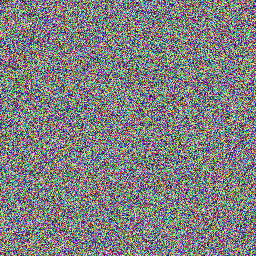

In [34]:
# --------------------------------------------------------------------
# Repack the encrypted data into an image object
# --------------------------------------------------------------------
img2CiphertextTuples = map(tuple,np.reshape(img2Ciphertext,(-1,3)))
img2 = img.copy()
img2.putdata(img2CiphertextTuples)
img2

### 5.3 Encrypt Image Using Counter (CTR) mode

In [35]:
# --------------------------------------------------------------------
# And now the thrilling climax, in which we encrypt our image data
# using the counter mode (CTR)
# --------------------------------------------------------------------

# Use previous encryption key
print "Key:", keyArray

# the coup de grâce
img3Ciphertext = Encrypt(imgArray,keyArray,mode='ctr')
print "Ciphertext: ", img3Ciphertext[:256] # display the first 256 bytes of the ciphertext data

# Make yourself comfortable. This takes a while to run.

Key: [46 65 7A 65 73 20 61 6E 64 20 62 6F 77 20 74 69]
Encrypting with mode ctr.
Processing block 123 of 12288 (1% complete)
Processing block 246 of 12288 (2% complete)
Processing block 369 of 12288 (3% complete)
Processing block 492 of 12288 (4% complete)
Processing block 615 of 12288 (5% complete)
Processing block 738 of 12288 (6% complete)
Processing block 861 of 12288 (7% complete)
Processing block 984 of 12288 (8% complete)
Processing block 1106 of 12288 (9% complete)
Processing block 1229 of 12288 (10% complete)
Processing block 1352 of 12288 (11% complete)
Processing block 1475 of 12288 (12% complete)
Processing block 1598 of 12288 (13% complete)
Processing block 1721 of 12288 (14% complete)
Processing block 1844 of 12288 (15% complete)
Processing block 1967 of 12288 (16% complete)
Processing block 2089 of 12288 (17% complete)
Processing block 2212 of 12288 (18% complete)
Processing block 2335 of 12288 (19% complete)
Processing block 2458 of 12288 (20% complete)
Processing block

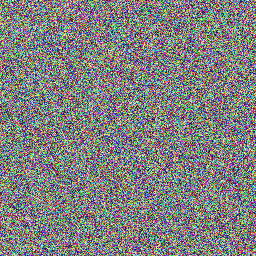

In [36]:
# --------------------------------------------------------------------
# Repack the encrypted data into an image object
# --------------------------------------------------------------------
img3CiphertextTuples = map(tuple,np.reshape(img3Ciphertext,(-1,3)))
img3 = img.copy()
img3.putdata(img3CiphertextTuples)
img3

## References

[DAEMEN 1999] Daemen, J., & Rijmen, V. (1999). **AES Proposal: Rijndael**. ([link](http://csrc.nist.gov/archive/aes/rijndael/Rijndael-ammended.pdf))

[DEEPLOOK 2013] Unknown, username deeplook. (2013). **An IPython notebook playing with display hook functions to display PIL images and Reportlab drawings**. Jupyter.org. Retrieved 28 February 2016 ([link](https://gist.github.com/deeplook/5162445))

[JAIN 2011] Jain, R. (2011). **Advanced Encryption Standard (AES)**. Presentation, Washington University in Saint Louis. ([link](http://www.cse.wustl.edu/~jain/cse571-11/ftp/l_05aes.pdf))

[MOSER 2009] Moser, J. (2009). **A Stick Figure Guide to the Advanced Encryption Standard (AES)**. Moserware.com. Retrieved 26 February 2016. ([link](http://www.moserware.com/2009/09/stick-figure-guide-to-advanced.html))

[NIST 2001] National Institute of Standards and Technology (2001). **Specification for the Advanced Encryption Standard (AES)**. Washington: Department of Commerce. ([link](http://csrc.nist.gov/publications/fips/fips197/fips-197.pdf))

[TRENHOLME 2005] Trenholme, S. (2005). **Rijndael's key schedule**. Samiam.org. Retrieved 26 February 2016. ([link](http://www.samiam.org/key-schedule.html))

[WIKI 2016a] Wikipedia (2016). **Block cipher mode of operation**. Retrieved 27 February 2016. ([link](https://en.wikipedia.org/wiki/Block_cipher_mode_of_operation))

[WIKI 2016b] Wikipedia (2016). **Rijndael S-box**. Retrieved 27 February 2016. ([link](https://en.wikipedia.org/wiki/Rijndael_S-box))


### Other Works Consulted

Berent, A. (2003). **Advanced Encryption Standard By Example** (v1.7). ([link](http://www.adamberent.com/documents/AESbyExample.pdf))

Chai, R. (2012). **Python AES implementation**. Gist. Retrieved 27 February 2016. ([link](https://gist.github.com/raullenchai/2920069))

Daemen, J., & Rijmen, V. (2001). **The Design of Rijndael**. Berlin: Springer-Verlag. ([link](http://jda.noekeon.org/JDA_VRI_Rijndael_2002.pdf))